# Adversarial Search: Playing "Mean" Connect 4


## Instructions

All student names in group: Safwan Kader, Jerry Xiao, Dylan Lai

I understand that my submission needs to be my own group's work: SK, JX, DL

I understand that ChatGPT / Copilot / other AI tools are not allowed: SK, JX, DL

Points: 10

Complete this notebook and submit it (save/print as pdf). The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play "Mean" Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

> **The mean part:** This game has an additional rule. Every time it is a player's turn, the player can decide to instead of playing a new disk, take a bottom row disk of the opponent and place it back in the top of the same column. All disks above the removed disk will fall down one position and the removed one will be placed on top. Note that a player can only move an _opponent's disc_ that is in the _bottom row_ of the board. **Further, you are not allowed to play a mean move if your opponent just played one.** This ensures the game will end at some point. This also may affect the definition of a board, compared with standard Connect 4.

If a mean move causes both players to win, the game immediately ends and it is a tie, even if one player has more connect-4s than the other one. If a mean move causes one player to win, then the game also ends and the player with the connect-4 is the winner.

Note that normal [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [1 point]

**Define the components of the search problem associated with this game:**

* Initial state
* Actions
* Transition model
* Test for the terminal state
* Utility for terminal states

- **Initial State (S₀):** 
  - The initial state is an empty Connect 4 board with no discs placed.
  
- **Actions (A):** 
  - Actions include dropping a disc in one of the seven columns or performing a mean move in one of the columns where the opponent has a disc in the bottom row.
  
- **Transition Model (Result function):** 
  - The transition model defines how the state changes based on the action taken. It returns the new state after applying the action. In this case, the transition model will show how the board will change after a mean move or regular move. 
  
  - *Result(s,a) -> a'* where s is the current state and a is the action taken. a' is the new state. 
  
- **Test for the terminal state:** 
  - We can define a function ```check_board``` which checks whether the game has reached a terminal state. This includes checking for a winner or a tie (full board). Terminal states only require at least one winner or ties. If multiple wins are detected, they will be ignored.
  
- **Utility for terminal states:** 
  - The utility function assigns utility values based on the outcome of the game. It returns a positive value if Max wins, a negative value if Min wins, and 0 for a tie.
 

**How big is the state space? Give an estimate and explain it.**

The state space is estimated as 3^(6*7) since each cell can have three states (empty, player 1, player 2) on a 6x7 board.



**How big is the game tree that minimax search will go through? Give an estimate and explain it.**

The game tree is estimated based on the branching factor (number of possible actions) raised to the depth of the tree. The depth is the maximum number of moves until the end of the game, which is typically less than 42 (6 rows * 7 columns).

## Task 2: Game Environment and Random Agent [3 point]

You can use a numpy character array as the board. Note that the following function can create boards of different sizes.

In [1]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


Instead of colors (red and yellow), you can use 1 and -1 to represent the players Max and Min. Make sure that your agent functions all have the from: `agent_type(state, player = 1)`, where board is the current board position and player is the player (1, -1) whose next move it is and who the agent should play.

Visualization code by Randolph Rankin:

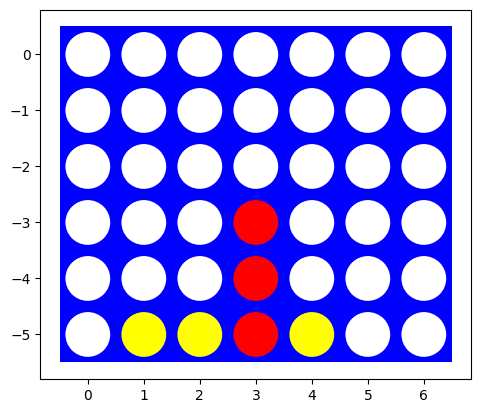

In [2]:
import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]

visualize(board)

Implement helper functions for:

* The transition model $result(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [3]:
import itertools

mean_allowed = True

def action(board, move, player):
    global mean_allowed
    new_board = [row.copy() for row in board]
    if move[0] == 'drop':
        mean_allowed = True
        column = move[1]
        for row in range(len(new_board) - 1, -1, -1):
            if new_board[row][column] == 0:
                new_board[row][column] = player 
                break
    elif move[0] == 'mean':
        mean_allowed = False
        column = move[1]
        row = len(new_board) - 1
        while new_board[row][column] != 0 and row > 0:
            new_board[row][column] = new_board[row - 1][column]
            row -= 1
        new_board[row + 1][column] = player * -1
    return new_board

def utility(board):
    
    if winner := check_board(board):
        rows = len(board)
        cols = len(board[0])

        # evaluate the board based on the number of connected pieces for the player
        player_count = count_pieces(board, 1, rows, cols)
        opponent_count = count_pieces(board, -1, rows, cols)

        if winner == 1:
            return 100 - opponent_count  # player 1 wins
        elif winner == -1:
            return -100 + player_count # player 2 wins


    return None

def count_pieces(board, player, rows, cols):
    return sum(
        1
        for i, j in itertools.product(range(rows), range(cols))
        if board[i][j] == player
    )


def is_winning_sequence(sequence):
    winning_sequences = [[1, 1, 1, 1], [-1, -1, -1, -1]]
    return next(
        (
            seq[0]
            for i, seq in itertools.product(
                range(len(sequence) - 3), winning_sequences
            )
            if all(sequence[i + j] == seq[j] for j in range(4))
        ),
        None,
    )


def check_board(board):
    # check rows
    for row in board:
        winner = is_winning_sequence(row)
        if winner is not None:
            return winner

    # check columns
    for col in range(len(board[0])):
        column_values = [board[row][col] for row in range(len(board))]
        winner = is_winning_sequence(column_values)
        if winner is not None:
            return winner

    # check diagonals
    for row in range(len(board) - 3):
        for col in range(len(board[0]) - 3):
            diagonal_values = [board[row + i][col + i] for i in range(4)]
            anti_diagonal_values = [board[row + 3 - i][col + i] for i in range(4)]

            winner = is_winning_sequence(diagonal_values)
            if winner is not None:
                return winner

            winner = is_winning_sequence(anti_diagonal_values)
            if winner is not None:
                return winner
    # TODO : Make a proper check for draws
    # check ties
    return 0 if all(cell != 0 for row in board for cell in row) else None

 


def available_actions(board, player):
    global mean_allowed
    actions = []
    
    for column in range(len(board[0])):
        if board[0][column] == 0: 
            actions.append(('drop', column))
            
        last_row = len(board) - 1
        
        if mean_allowed:
            if board[last_row][column] == (player * -1) and board[last_row - 1][column] != 0:
                actions.append(('mean', column))
                
    return actions


Implement an agent that plays randomly. Make sure the agent function receives as the percept the game state and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(state, player = None): ...`

The argument `player` is used for agents that do not store what side they are playing. The value passed on by the environment should be 1 ot -1 for playerred and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [4]:
import random

def random_player(board, player = None):
    action = available_actions(board, player)
    return random.choice(action) if action else None

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [5]:
def switch_player(player):
    return -1 if player == 1 else 1

def play(N = 1000):
    """Let two agents play each other N times. x starts. x and y are agent functions that 
    get the board as the percept and return their next action."""
    
    results = {'1': 0, '-1': 0, '0': 0}


    for _ in range(N):
        board = empty_board()
        player = 1

        while True:

            if move := random_player(board, player):
                board = action(board, move, player)

            if win := check_board(board):
                results[str(win)] += 1
                break

            player = switch_player(player)   

    return results

play()

{'1': 589, '-1': 411, '0': 0}

## Task 3: Minimax Search with Alpha-Beta Pruning [3 points]

### Implement the search starting.

Implement the search starting from a given state and specifying the player and put it into an agent function.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Notes:__
* Make sure that all your agent functions have a signature consistent with the random agent above.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [6]:
import math

# global variables
DEBUG = 1  # 1 ... count nodes, 2 ... debug each node
COUNT = 0

def alpha_beta_search(board, player=1, move_ordering=None):
    # sourcery skip: move-assign
    """Start the search."""
    global DEBUG, COUNT
    COUNT = 0
    
    value, move = max_value_ab(board, player, -math.inf, +math.inf, move_ordering)
    if DEBUG >= 1:
        print(f"Number of nodes searched: {COUNT}") 
    
    return value, move

def max_value_ab(state, player, alpha, beta, move_ordering):
    """Player's best move."""
    global DEBUG, COUNT
    COUNT += 1
    
    # Return utility of state if it is a terminal state
    if DEBUG >= 2:
        print(f"max: {state} [alpha,beta]=[{alpha},{beta}]")
    
    v = utility(state)
    if v is not None:
        if DEBUG >= 2:
            print("     Found terminal state. Backtracking.")
        return v, None

    v, move = -math.inf, None

    # Check all possible actions in the state, update alpha, and return the move with the largest value
    actions = move_ordering(available_actions(state, player), board) if move_ordering else available_actions(state, player)
    for a in actions:
        v2, a2 = min_value_ab(action(state, a, player), player, alpha, beta, move_ordering)
        if DEBUG >= 2:
            print(f"max: {state} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta:
            if DEBUG >= 2:
                print("     v>=beta ({v}>={beta}): Pruning remaining subtree (actions). Backtracking.")
            return v, move

    return v, move

def min_value_ab(state, player, alpha, beta, move_ordering):
    """Opponent's best response."""
    global DEBUG, COUNT
    COUNT += 1

    # Return utility of state if it is a terminal state
    if DEBUG >= 2:
        print(f"min: {state} [alpha,beta]=[{alpha},{beta}]")
    
    v = utility(state)
    if v is not None:
        if DEBUG >= 2:
            print("     Found terminal state. Backtracking.")
        return v, None

    v, move = +math.inf, None

    # Check all possible actions in the state, update beta, and return the move with the smallest value
    actions = move_ordering(available_actions(state, -player), board) if move_ordering else available_actions(state, -player)
    for a in actions:
        v2, a2 = max_value_ab(action(state, a, switch_player(player)), player, alpha, beta, move_ordering)
        if DEBUG >= 2:
            print(f"min: {state} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha:
            if DEBUG >= 2:
                print("     v<=alpha ({v}<={alpha}): Pruning remaining subtree (actions). Backtracking.")
            return v, move

    return v, move


Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.


Board 1 (column):


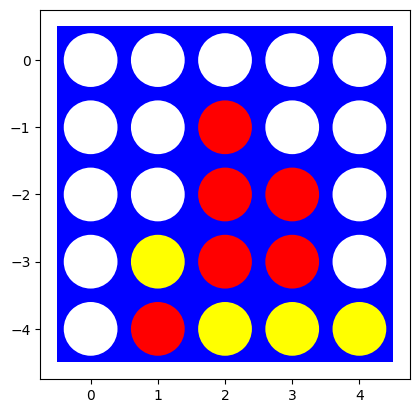


Number of nodes searched: 137762


(96, ('drop', 2))

CPU times: user 4.8 s, sys: 3.78 ms, total: 4.8 s
Wall time: 4.4 s

Board 2 (column):


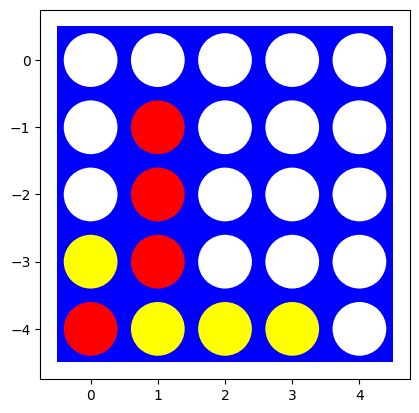


Number of nodes searched: 118716


(96, ('drop', 1))

CPU times: user 4.37 s, sys: 2.94 ms, total: 4.38 s
Wall time: 3.95 s

Board 3 (diagonal):


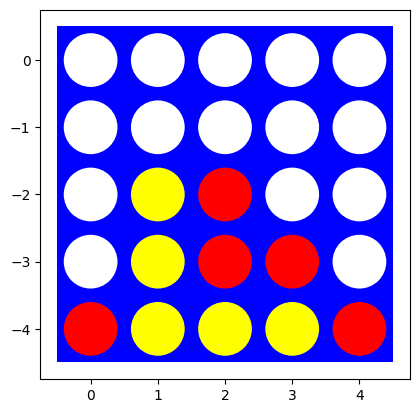


Number of nodes searched: 225047


(95, ('drop', 1))

CPU times: user 7.73 s, sys: 2.27 ms, total: 7.73 s
Wall time: 7.31 s

Board 4 (anti-diagonal):


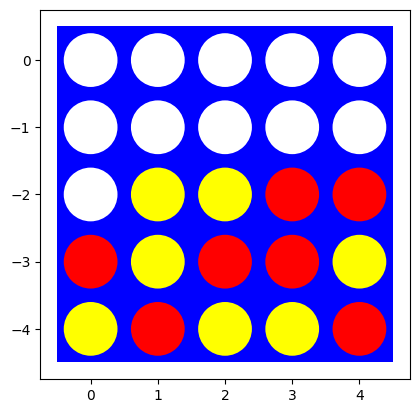


Number of nodes searched: 973496


(93, ('drop', 4))

CPU times: user 33 s, sys: 9.28 ms, total: 33 s
Wall time: 32.7 s

Board 5 (row):


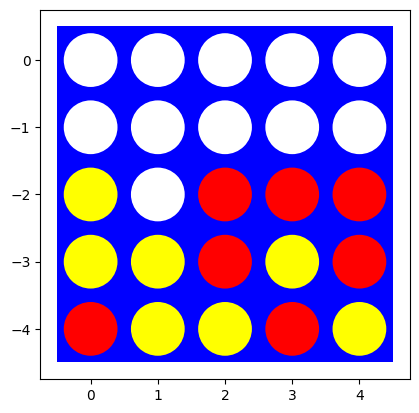


Number of nodes searched: 110663


(93, ('drop', 1))

CPU times: user 4.01 s, sys: 1.97 ms, total: 4.01 s
Wall time: 3.58 s

Board 7 (block):


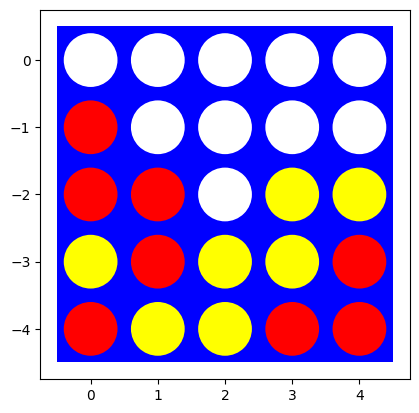


Number of nodes searched: 359293


(-89, ('drop', 4))

CPU times: user 12.3 s, sys: 4.37 ms, total: 12.3 s
Wall time: 12 s


In [7]:




# win in column 2
board1 = [[0, 0, 0, 0, 0],
          [0, 0, 1, 0, 0],
          [0, 0, 1, 1, 0],
          [0, -1, 1, 1, 0],
          [0, 1,-1,-1,-1]]
print()
print("Board 1 (column):")
visualize(board1)
print()
%time display(alpha_beta_search(board1))
# win in column 1
board2 = [
          [0, 0, 0, 0, 0],
          [0, 1, 0, 0, 0],
          [0, 1, 0, 0, 0],
          [-1, 1, 0, 0, 0],
          [1,-1,-1,-1, 0]]
print()
print("Board 2 (column):")
visualize(board2)

print()
%time display(alpha_beta_search(board2))

# win in diagonal
board3 = [
          [0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0],
          [0, -1, 1, 0, 0],
          [0, -1, 1, 1, 0],
          [1,-1, -1,-1, 1]]

print()
print("Board 3 (diagonal):")
visualize(board3)

print()
%time display(alpha_beta_search(board3))
# win in anti-diagonal
board4 = [
          [0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0],
          [0, -1, -1, 1, 1],
          [1, -1, 1, 1, -1],
          [-1, 1, -1, -1, 1]]

print()
print("Board 4 (anti-diagonal):")
visualize(board4)

print()
%time display(alpha_beta_search(board4))
# win in row 4
board5 = [
          [0, 0, 0, 0, 0,],
          [0, 0, 0, 0, 0,],
          [-1, 0, 1, 1, 1 ],
          [-1, -1, 1,-1, 1],
          [1,-1,-1, 1,-1 ]]
print()
print("Board 5 (row):")
visualize(board5)

print()
%time display(alpha_beta_search(board5))


board7 = [
          [0, 0, 0, 0, 0],
          [1, 0, 0,  0,  0],
          [1, 1,  0, -1, -1],
          [-1, 1, -1, -1, 1],
          [1,-1, -1, 1, 1]]

print()
print("Board 7 (block):")
visualize(board7)

print()
%time display(alpha_beta_search(board7))



How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.


Board 1 (column):


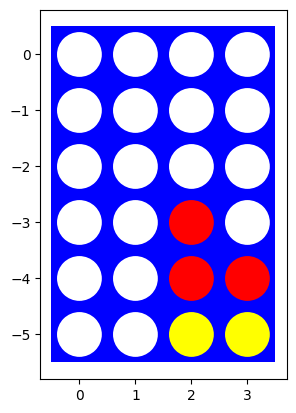

KeyboardInterrupt: 


Board 2 (column):


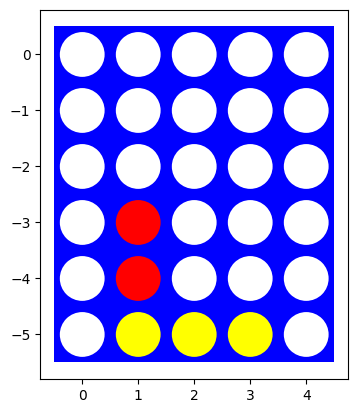

In [24]:
import timeit
import matplotlib.pyplot as plt


# win in column 2
board1 = [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 1, 0],
          [0, 0, 1, 1],
          [0, 0,-1,-1]]
print()
print("Board 1 (column):")
visualize(board1)

print()
%time display(alpha_beta_search(board1))

# win in column 1
board2 = [[0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0],
          [0, 1, 0, 0, 0],
          [0, 1, 0, 0, 0],
          [0,-1,-1,-1, 0]]
print()
print("Board 2 (column):")
visualize(board2)

print()
%time display(alpha_beta_search(board2))

# win in diagonal
board3 = [[0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0],
          [0, -1, 0, 0, 0, 0],
          [0, -1, 1, 1, 0, 0],
          [0,-1, -1,-1, 1, 0]]

print()
print("Board 3 (diagonal):")
visualize(board3)

print()
%time display(alpha_beta_search(board3))
# win in anti-diagonal
board4 = [[0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0],
          [0, -1, -1, 0, 1, 0, 0],
          [0, -1, 1, 0, -1, 0, 0],
          [0, 1, -1, -1, 1, 0, 0]]

print()
print("Board 4 (anti-diagonal):")
visualize(board4)

print()
%time display(alpha_beta_search(board4))
# win in row 4
board5 = [[0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 1, 1, 0, 0, 0, 0],
          [0, 0, 1,-1, 1, -1, 0, 0],
          [0,-1,-1, 1,-1, -1, 0, 0]]
print()
print("Board 5 (row):")
visualize(board5)

print()
%time display(alpha_beta_search(board5))


print("\nTime measurements with increasing board size:\n")

def measure_time(board):
    return timeit.timeit(lambda: alpha_beta_search(board), number=1)

boards = [board1, board2, board3, board4, board5]

times = [measure_time(board) for board in boards]
# Plot the results
plt.plot(range(4, 9), times, marker='o')
plt.title('Time vs Columns')
plt.xlabel('Columns')
plt.ylabel('Time (seconds)')
plt.show()


### Move ordering

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move.

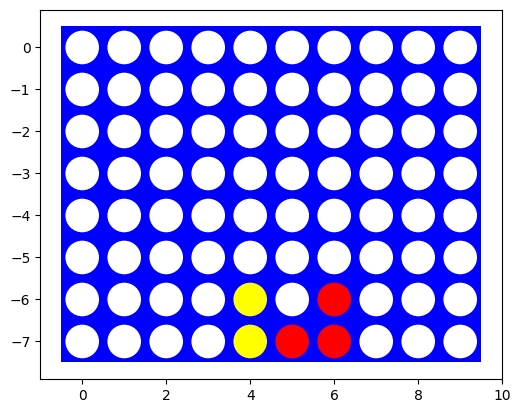


Board with no move ordering:

Number of nodes searched: 12


{'move': ('drop', 5), 'value': 5}

CPU times: user 11 ms, sys: 156 µs, total: 11.2 ms
Wall time: 3.68 ms

Board with center move ordering:

Number of nodes searched: 12


{'move': ('drop', 5), 'value': 5}

CPU times: user 11 ms, sys: 176 µs, total: 11.2 ms
Wall time: 3.6 ms

Board with odd row ordering:

Number of nodes searched: 14


{'move': ('drop', 5), 'value': 5}

CPU times: user 16.8 ms, sys: 473 µs, total: 17.3 ms
Wall time: 6.15 ms

Board with center and edge move ordering:

Number of nodes searched: 12


{'move': ('drop', 5), 'value': 5}

CPU times: user 28.8 ms, sys: 592 µs, total: 29.4 ms
Wall time: 12.9 ms

Board with blocking ordering:

Number of nodes searched: 12


{'move': ('drop', 5), 'value': 5}

CPU times: user 26.6 ms, sys: 489 µs, total: 27.1 ms
Wall time: 9.5 ms

Time measurements with different orderings:

Number of nodes searched: 12
Number of nodes searched: 14
Number of nodes searched: 14
Number of nodes searched: 12
Number of nodes searched: 12
Number of nodes searched: 12


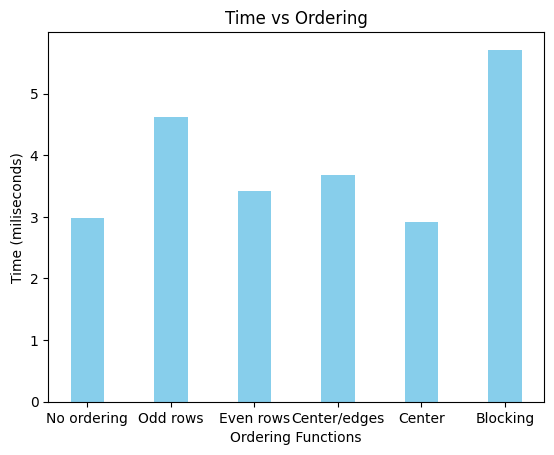

In [284]:
board = [
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  
    [0, 0, 0, 0, -1, 0, 1, 0, 0, 0],  
    [0, 0, 0, 0, -1, 1, 1, 0, 0, 0],  
]



# move ordering functions

def prioritize_center_moves(moves, board):
    center_columns = [len(board) // 2, len(board) // 2 + 1]  
    center_moves = [move for move in moves if move[1] in center_columns]
    other_moves = [move for move in moves if move not in center_moves]
    return center_moves + other_moves

def prioritize_odd_rows(moves, board):
    odd_columns = [i % 2 != 0 for i in range(len(board))]
    odd_moves = [move for move in moves if move[1] in odd_columns]
    other_moves = [move for move in moves if move not in odd_columns]
    return odd_moves + other_moves

def prioritize_even_rows(moves, board):
    odd_columns = [i % 2 == 0 for i in range(len(board))]
    odd_moves = [move for move in moves if move[1] in odd_columns]
    other_moves = [move for move in moves if move not in odd_columns]
    return odd_moves + other_moves
    
def prioritize_center_and_edges_moves(moves, board):
    center_columns = [len(board) // 2, len(board) // 2 + 1]  
    edge_columns = [0, 1, len(board) - 1, len(board) - 2]
    center_moves = [move for move in moves if move[1] in center_columns]
    edge_moves = [move for move in moves if move[1] in edge_columns]
    other_moves = [move for move in moves if move not in center_moves and move not in edge_moves]
    return center_moves + edge_moves + other_moves

def prioritize_blocking_moves(moves, board):
    prioritized_moves = []

    for move in moves:
        new_board = action(board, move, 1)
        if check_board(new_board):
            # Move blocks the opponent from winning, prioritize it
            prioritized_moves.insert(0, move)
        else:
            # Non-blocking moves go at the end
            prioritized_moves.append(move)

    return prioritized_moves



visualize(board)
print()
print("Board with no move ordering:")


print()
%time display(alpha_beta_search(board))

print()
print("Board with center move ordering:")

print()
%time display(alpha_beta_search(board,1, prioritize_center_moves))

print()
print("Board with odd row ordering:")

print()
%time display(alpha_beta_search(board,1, prioritize_odd_rows))

print()
print("Board with center and edge move ordering:")

print()
%time display(alpha_beta_search(board,1, prioritize_center_and_edges_moves))


print()
print("Board with blocking ordering:")

print()
%time display(alpha_beta_search(board,1, prioritize_blocking_moves))

print("\nTime measurements with different orderings:\n")

def measure_time(ordering, board):
    return timeit.timeit(lambda: alpha_beta_search(board, 1, ordering), number=1) * 1000

orderings = [None, prioritize_odd_rows, prioritize_even_rows, prioritize_center_and_edges_moves, prioritize_center_moves, prioritize_blocking_moves]
ordering_functions = ["No ordering", "Odd rows", "Even rows", "Center/edges", "Center", "Blocking"]
times = [measure_time(ordering, board) for ordering in orderings]
# Plot the results
plt.bar(ordering_functions, times, color='skyblue', width=0.4)
plt.title('Time vs Ordering')
plt.xlabel('Ordering Functions')
plt.ylabel('Time (miliseconds)')
plt.show()




### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

- **Empty board**
    - As mentioned, having an empty board causes the minimax algorithm with alpha beta prunng to run in the worst case scenario. This is because all of possible routes are taken into account before making a move. Since we are using depth-first search, the algorithm must search one possible scenario before traversing further scenarios. Thanks to pruning, we can ignore certain branches. However, in a larger state space such as this

- **Optimization**

### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [ ]:
# Your code/ answer goes here.

## Task 4: Heuristic Alpha-Beta Tree Search [3 points]

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

In [ ]:
# Your code/ answer goes here.

### Cutting off search

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [ ]:
# Your code/ answer goes here.

Experiment with the same manually created boards as above to check if the agent spots winning opportunities.

In [ ]:
# Your code/ answer goes here.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [ ]:
# Your code/ answer goes here.

### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [ ]:
# Your code/ answer goes here.

---
Assignment adapted from [Michael Hahsler](https://github.com/mhahsler/CS7320-AI) under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/deed.en) license.
